# Анализ оттока клиентов

## Цели исследования

В нашем распоряжении датасет о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Основная цель - проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.

**Описание данных**
- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity`  — количество баллов собственности,
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `EST_SALARY` — заработная плата клиента,
- `churn` — ушёл или нет (1 - ушел, 0 - не ушел).

Исследование будет состоять из нескольких пунктов - задач:
 - знакомство с данными и предобработка - выявление и анализ дубликатов, пропусков и аномалий
 - исследовательский анализ данных - поиск связи между столбцами-характеристиками клиентов банка и их уходом, анализ коореляции в данных
 - проверка гипотез 
   - гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались
   - гипотеза, которая будет сформулирована на основе дальнейшего анализа

- на основе исследовательского анализа и проверенных гипотез формируем несколько сегментов наиболее отточных пользователей и приоритезируем сегменты
- формирование вывода и рекомендаций на основе проведенного анализа

## Исследование данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt
import numpy as np
from scipy.stats import levene

In [2]:
plt.style.use("seaborn")

### Знакомство с данными

In [3]:
try:
    data = pd.read_csv('bank_scrooge.csv')
except:
    path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
    data = pd.read_csv(path)

In [4]:
data

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [6]:
data.loc[:,'score':].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000,9974,10000,7705,10000,10000,10000,10000,10000
mean,848.699,42.7344,2.6276,827794,1.8701,0.6804,0.5235,147867,0.182
std,65.4485,12.18,1.98084,1.98061e+06,0.792647,0.466345,0.499472,139389,0.385864
min,642,18,0,0,0,0,0,2546.3,0
25%,802,33,0,295554,1,0,0,75251.9,0
50%,853,40,3,524272,2,1,1,119658,0
75%,900,51,4,980706,2,1,1,174501,0
max,1000,86,9,1.19114e+08,5,1,1,1.39506e+06,1


В нашем распоряжении данные о 10 тысячах клиентах. В данных присутсвуют пропуски в столбцах о возрасте и балансе клиентов. Все типы столбцов соответсвуют данным. В денежных колонках `balance` и `EST_SALSRY` присутсвуют выбросы.

### Предобработка данных

In [7]:
# приведем названия столбцов к единому стилю
data = data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary', 'last_activity': 'is_active'})

In [8]:
# проверим наличие явных дубликатов
print('В таблице', data.duplicated().sum(), 'дубликатов.')

В таблице 0 дубликатов.


In [9]:
# проверим уникальность id клиентов
data[data['user_id'].duplicated()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,is_active,est_salary,churn
1583,190253,726.0,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0
1837,210662,896.0,Рыбинск,Ж,37.0,0,NaN,2,0,0,90916.04,0
2138,131419,739.0,Рыбинск,Ж,37.0,3,1307941.65,3,0,0,103867.47,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2302,220816,934.0,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
9785,168998,895.0,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0
9880,217412,886.0,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0


В таблице 73 записи неявно дублируют информацию о пользователях.

Рассмотрев несколько пар дублирования id, можно заметить, что данные не дублируются, кроме идентификатора у пользователей нет почти ничего общего. Можно предположить, что в разных городах идет разная нумерация пользователей. В любом случае дублирования не происходит, поэтому данные лучше сохранить, но иметь в виду, что группировка по id не будет уникальной.

Проверим, нет ли неявных дубликатов в строковых данных.

In [10]:
print(data.city.unique())
print(data.gender.unique())

['Рыбинск' 'Ярославль' 'Ростов']
['Ж' 'М']


Все значения в колонках строкового типа различны, неяные дубликаты не обнаружены.

Изучим пропуски. Есть ли какая-то связь между пропусками в наших данных и другими показателями?

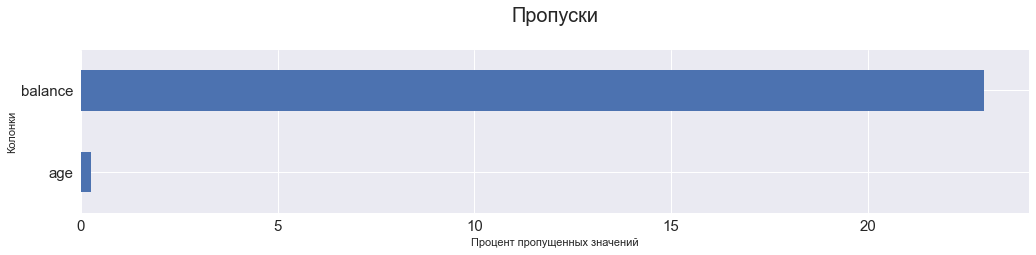

In [11]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.set_title('Пропуски' + "\n", fontsize = 20)
((data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (17,3), legend = False, fontsize = 15, ax=ax))
plt.xlabel("Процент пропущенных значений")
plt.ylabel("Колонки");

Все пропуски относятся к непреревным переменным. В колонке возраста число пропусков незначительное - меньше 1 процента. А вот в колонке баланса почти четверть данных составляют пропуски.

Можно предположить, что данные неактивных или отточных клиентов могут содержать пропуски. Также данных о балансе может не быть, если он нулевой. Для проверки этих связей и выявление других, составим сводные таблицы о средних показателях клиентов в разрезе наличия пропусков в одном и столбцов.

Посчитаем меру центральной тенденции в данных с пропуском и без в колонке возраст:

In [12]:
# составляем сводную таблицу для данных без возраста
dt_mn = data.query('age.isna()').loc[:, ['credit_card', 'is_active', 'churn']].mean()
dt_mdn = data.query('age.isna()').loc[:,['score', 'balance', 'est_salary', 'products', 'equity']].median()
dt_md = data.query('age.isna()').loc[:,['city', 'gender']].mode().T

no_age_dt = pd.concat([dt_mn, dt_mdn, dt_md])
no_age_dt.columns = ['no_age']

# составляем сводную таблицу для данных с возрастом
dt_mn = data.query('~ age.isna()').loc[:, ['credit_card', 'is_active', 'churn']].mean()
dt_mdn = data.query('~ age.isna()').loc[:,['score', 'balance', 'est_salary', 'equity', 'products']].median()
dt_md = data.query('~ age.isna()').loc[:,['city', 'gender']].mode().T

with_age_dt = pd.concat([dt_mn, dt_mdn, dt_md])
with_age_dt.columns = ['with_age']

In [13]:
no_age_dt.join(with_age_dt)

,no_age,with_age
credit_card,0.769231,0.680168
is_active,0.769231,0.522859
churn,0.038462,0.182374
score,888.5,853.0
balance,417361.115,524295.33
est_salary,142598.86,119626.795
products,1.0,2.0
equity,0.0,3.0
city,Ярославль,Ярославль
gender,М,М


In [14]:
display(data.query('~ age.isna()')[['score', 'equity', 'balance',
                                    'products', 'credit_card', 'is_active',
                                    'est_salary', 'churn']].corr()['churn'])
display(data[['score', 'equity', 'balance', 'products', 'credit_card',
              'is_active', 'est_salary', 'churn']].corr()['churn'])

score          0.106404
equity         0.270084
balance        0.085915
products       0.300621
credit_card   -0.130388
is_active      0.169420
est_salary     0.001705
churn          1.000000
Name: churn, dtype: float64

score          0.105962
equity         0.270559
balance        0.085577
products       0.300964
credit_card   -0.130790
is_active      0.168767
est_salary     0.001273
churn          1.000000
Name: churn, dtype: float64

Разница между выборками очень большая, поэтому разница в средних показателях вполне ожидаема. Бинарные показатели разнятся примерно на 20% друг от друга - среди клиентов без возраста больший процент имеют кредитную карту, являются активными и не отточными. Большая разница в среднем балансе клиента, есть разница в среднем количестве баллов собственности.
Однако данные без пропсуков в возрасте имеют ту же корреляцию, что и данные вообще. Следовательно пропуски имеют случайный характер и от них можно избавиться. Тем более, что их число составляет < 1% от всех данных.

In [15]:
data = data.dropna(subset=['age']) 

Посчитаем меру центральной тенденции в данных с пропуском и без в колонке баланс:

In [16]:
# составляем сводную таблицу для данных без баланса
dt_mn = data.query('balance.isna()').loc[:, ['credit_card', 'is_active', 'churn']].mean()
dt_mdn = data.query('balance.isna()').loc[:,['score', 'age', 'est_salary', 'products', 'equity']].median()
dt_md = data.query('balance.isna()').loc[:,['city', 'gender']].mode().T

no_bal_dt = pd.concat([dt_mn, dt_mdn, dt_md])
no_bal_dt.columns = ['no_balance']

# составляем сводную таблицу для данных с балансрм
dt_mn = data.query('~ balance.isna()').loc[:, ['credit_card', 'is_active', 'churn']].mean()
dt_mdn = data.query('~ balance.isna()').loc[:,['score', 'age', 'est_salary', 'products', 'equity']].median()
dt_md = data.query('~ balance.isna()').loc[:,['city', 'gender']].mode().T

with_bal_dt = pd.concat([dt_mn, dt_mdn, dt_md])
with_bal_dt.columns = ['with_balance']

In [17]:
no_bal_dt.join(with_bal_dt)

,no_balance,with_balance
credit_card,0.81527,0.640156
is_active,0.548925,0.51514
churn,0.005704,0.234698
score,903.0,840.0
age,40.0,40.0
est_salary,174347.87,106250.18
products,1.0,2.0
equity,0.0,4.0
city,Ярославль,Ярославль
gender,М,Ж


In [18]:
display(data.query('~ balance.isna()')[['score', 'equity', 'age', 'products', 'credit_card', 'is_active', 'est_salary', 'churn']].corr()['churn'])
display(data[['score', 'equity', 'age', 'products', 'credit_card', 'is_active', 'est_salary', 'churn']].corr()['churn'])

score          0.198325
equity         0.137573
age           -0.068734
products       0.220367
credit_card   -0.104854
is_active      0.210851
est_salary     0.119406
churn          1.000000
Name: churn, dtype: float64

score          0.106404
equity         0.270084
age           -0.049797
products       0.300621
credit_card   -0.130388
is_active      0.169420
est_salary     0.001705
churn          1.000000
Name: churn, dtype: float64

Пользователи с заполненными и не заполненными данными уже имеют более схожие размеры. Сильно разнятся показатели баллов собственности. У клиентов без баланса - в среднем 0 баллов, у клиентов с балансом - 4 из 9 возможных. Также отличается гендер, зарплат, факт оттока и баллы кредитного скоринга. Также интересно заметить, что у клиентов с пропусками в балансе в основном всего 1 продукт банка - кредитная карта.
Также видно, что корреляция в данных поменялась.
Из этого делаем вывод, что пропуски не случайны и вносить изменения в них будет некорректно.

Теперь изучим выбросы и аномалии. Для проверки гипотез данные не должны иметь выбросы.

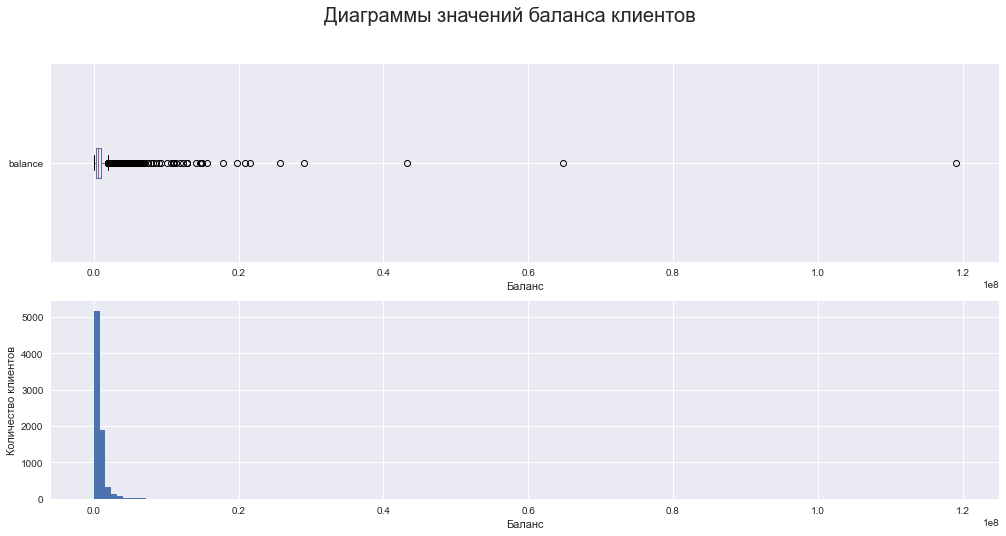

In [19]:
fig = plt.figure(figsize=(17,8))

axs0 = fig.add_subplot(2,1,1)
axs1 = fig.add_subplot(2,1,2)

axs0.set_xlabel('Баланс')
axs1.set_xlabel('Баланс')
axs1.set_ylabel('Количество клиентов')

data[['balance']].boxplot(vert = False, ax=axs0)
axs1 = data['balance'].hist(bins = 150)

fig.suptitle('Диаграммы значений баланса клиентов', fontsize=20);

In [20]:
np.percentile(data.query('~ balance.isna()').balance, [90, 95, 99])

array([1460133.708, 2114078.394, 4827211.159])

На графиках видно, что выбросы становятся редкими примерно на 10 млн. Менее 10% клиентов имеют баланс больше 2 млн и всего 1% имеет баланс более 5 млн. Причем максимум превышет 100 млн.

In [21]:
# уберем пользователей с аномально большим балансом
data['balance'] = data['balance'].fillna(-1)
data = data.loc[data['balance'] <= 4000000]
data.loc[data['balance'] == -1, 'balance'] = np.NaN

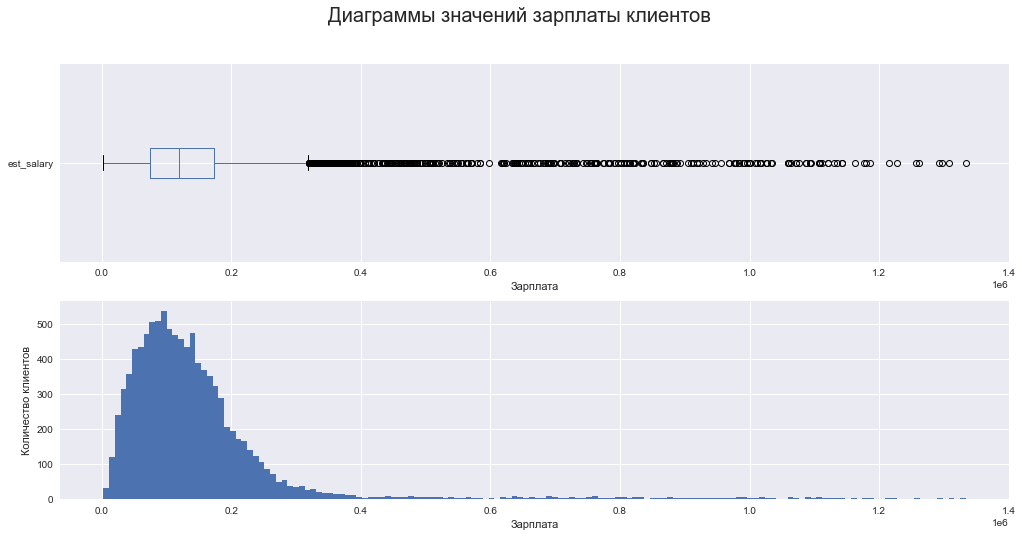

In [22]:
fig = plt.figure(figsize=(17,8))

axs0 = fig.add_subplot(2,1,1)
axs1 = fig.add_subplot(2,1,2)

axs0.set_xlabel('Зарплата')
axs1.set_xlabel('Зарплата')
axs1.set_ylabel('Количество клиентов')

data[['est_salary']].boxplot(vert = False, ax=axs0)
axs1 = data['est_salary'].hist(bins = 150)

fig.suptitle('Диаграммы значений зарплаты клиентов', fontsize=20);

In [23]:
np.percentile(data.est_salary, [1, 5, 90, 95, 99])

array([ 17318.3258,  31747.363 , 235857.844 , 297383.451 , 811524.337 ])

У зарплаты выбросы не такие большие, как у баланса. Менее 10% клиентов имеют зарплату превышающую 250 тыс и лишь 1% имеют зарплату выше 820 тыс. При этом максимум превышает 1 миллион. Также минимальная зарплата менее МРОТ выглядит неправдоподобно. Поставим нижнюю границу в 14 тыс, тем более что лишь 1% клиентов имеет зарплату ниже 17 тыс.

In [24]:
# уберем пользователей с аномально большой зарплатой
data = data.query('14000 <= est_salary <= 500000')

In [25]:
print('После удаления аномалий и клиентов с пропусками в возрасте мы потеряли', 10000 - data.shape[0], 'строк (клиентов) - это составляет',
     round(100 - data.shape[0] / 10000 * 100, 2), '%')

После удаления аномалий и клиентов с пропусками в возрасте мы потеряли 398 строк (клиентов) - это составляет 3.98 %


Удаление аномалий не привело к критической потере данных.

Для дальнейшего анализа категорийные текстовые столбцы необходимо кодировать.

In [26]:
df = data.join(pd.get_dummies(data[['city', 'gender']])).drop(columns=['city', 'gender'])

## Исследовательский анализ данных

Для каждой характеристики клиента посмотрим как она рапределена и как связанна с оттоком.

In [27]:
# функция, которая будет делать график распределения величины
# и график распределения относительно оттока
def plot_kde(param, title):
    fig = plt.figure(figsize = (17,17))

    axs0 = fig.add_subplot(2,1,1)
    axs1 = fig.add_subplot(2,1,2)

    sns.histplot(df[param], kde=True, stat="density", ax=axs0)
    sns.histplot(data = df, x=param, kde=True, hue='churn', stat="density", common_norm=False, ax=axs1)

    axs0.set_title('Распределение ' + title + '\n', fontsize = 15)
    axs1.set_title('Распределение ' + title + ' относительно оттока' + '\n', fontsize = 15);

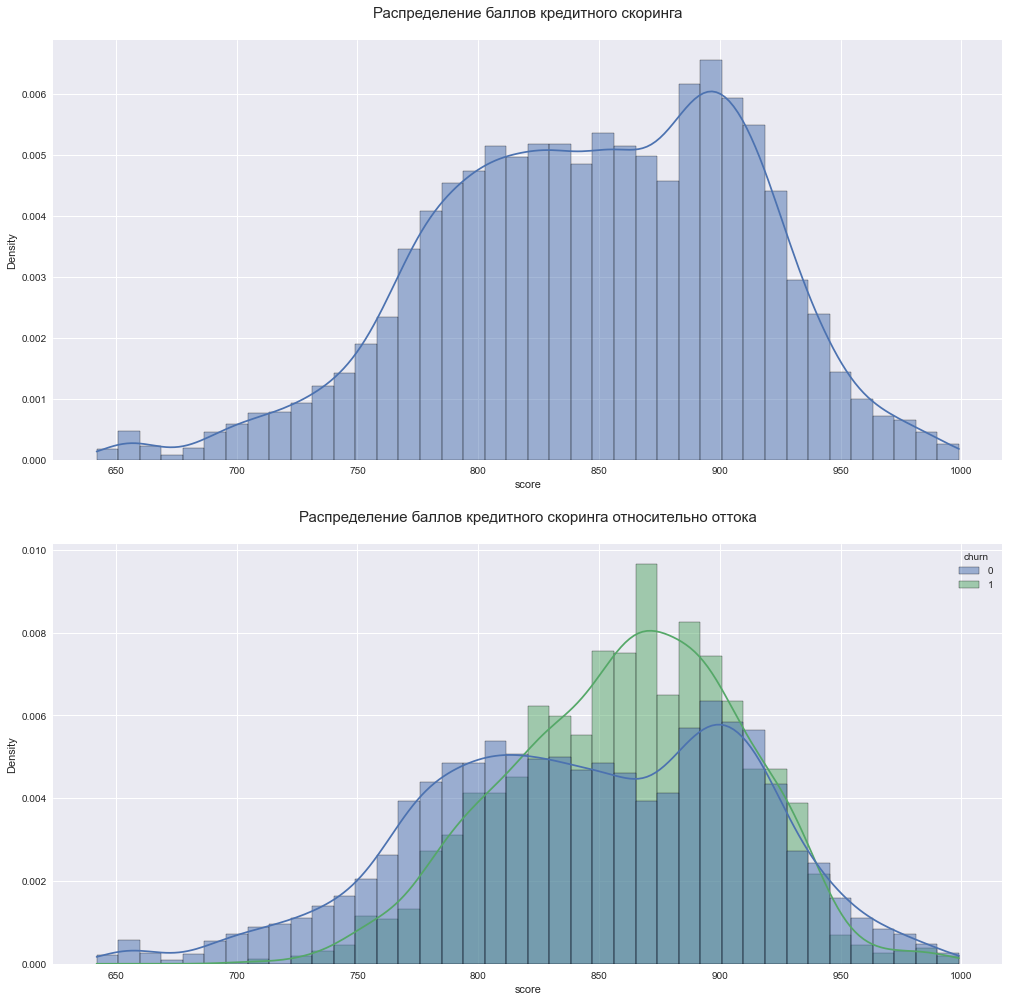

In [28]:
plot_kde('score', 'баллов кредитного скоринга')

Кредитный скоринг в зависимости от оттока имеет различное распределение. В обоих случаях графики скошены. Распределение отточных пользователей имеет более нормальный вид. Распределение же не отточных клиентов будто совмещает два распределения, имеет две вершины - наиболее частых значения.

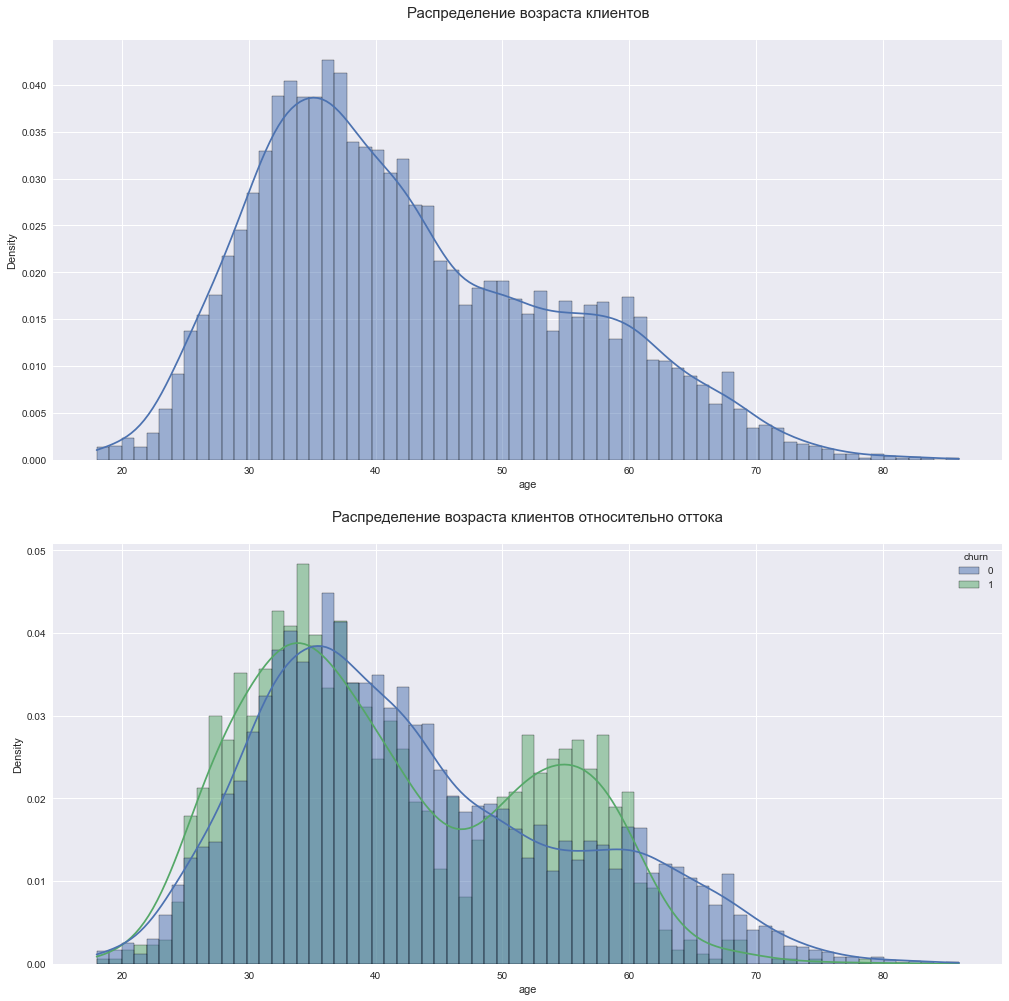

In [29]:
bins = int(df['age'].max() - df['age'].min() + 1)
fig = plt.figure(figsize = (17,17))

axs0 = fig.add_subplot(2,1,1)
axs1 = fig.add_subplot(2,1,2)

sns.histplot(df['age'], kde=True, stat="density", ax=axs0, bins=bins)
sns.histplot(data = df, x='age', kde=True, hue='churn', stat="density", common_norm=False, ax=axs1, bins=bins)

axs0.set_title('Распределение возраста клиентов' + '\n', fontsize = 15)
axs1.set_title('Распределение возраста клиентов относительно оттока' + '\n', fontsize = 15);

В возрасте ситуация обратна скорингу. Отточные клиенты имеют два явных всплеска в данных - около 35 и 55 лет. Распределения в целом имеют достаточно схожий вид, за исключением второго всплеска у отточных.

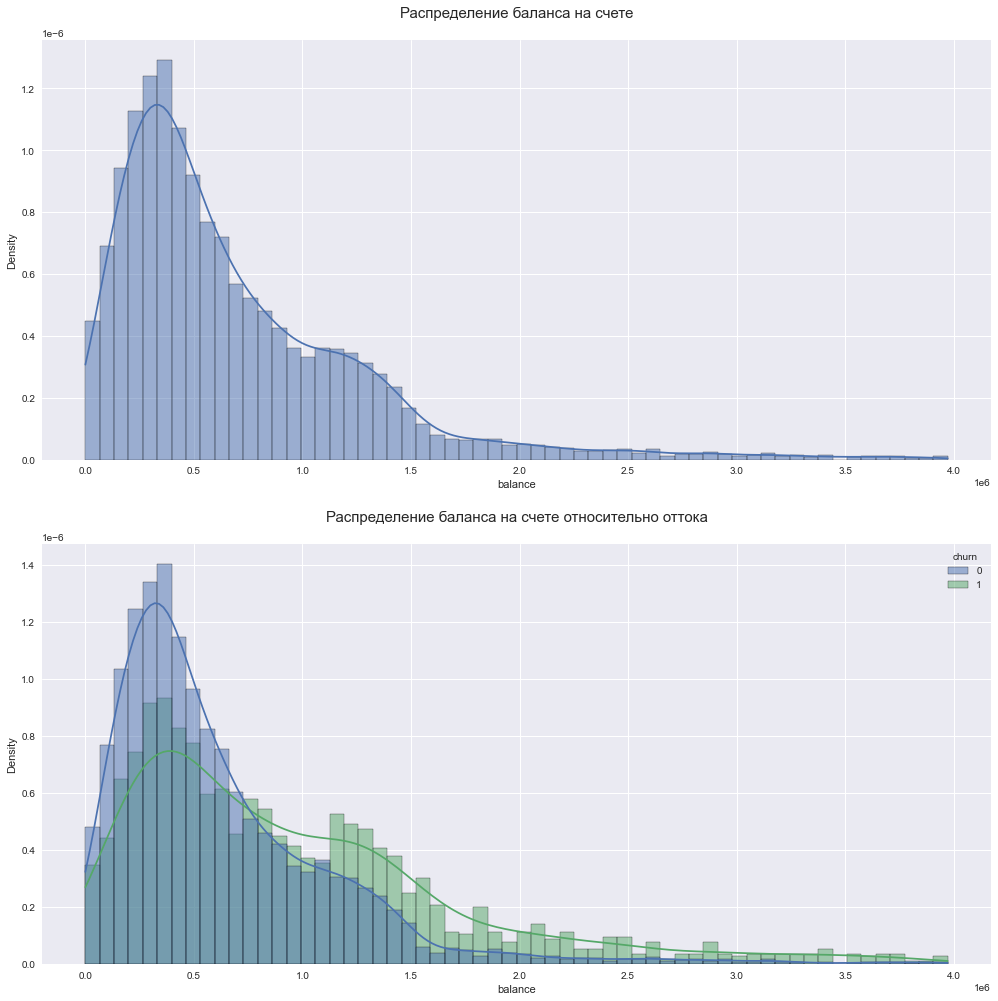

In [30]:
plot_kde('balance', 'баланса на счете')

Даже после удаления выбросов распределение остается очень скошенным. У отточных пользователей, судя по графику, также как и у не отточных большая часть данных сосредоточенна в районе 500 тысяч, однако у отточных также есть большое скопление в районе 1.5 миллиона.

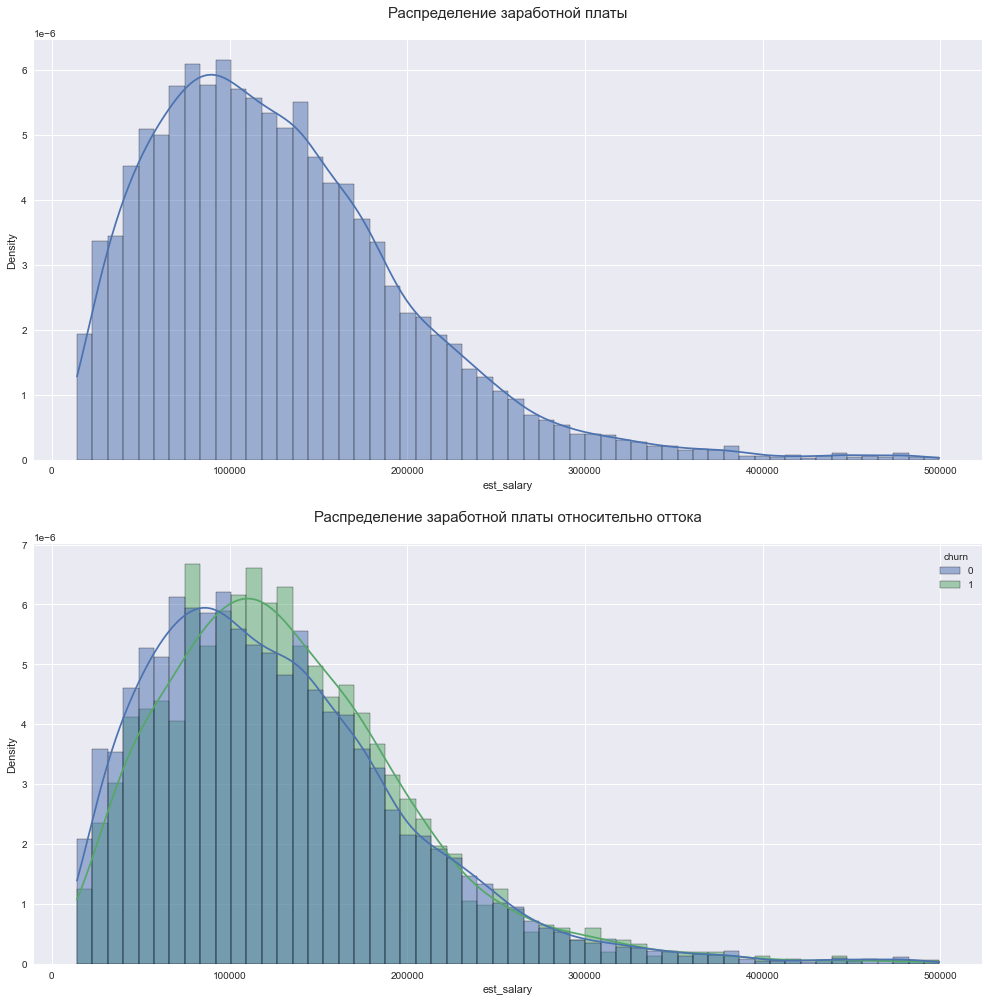

In [31]:
plot_kde('est_salary', 'заработной платы')

Распределения заработной платы почти не отличаются. В обоих случаях наиболее частым значением является зп в районе 100 тыс.

In [32]:
# функция для построения распределения дискретных и кодированных признаков с уровнем оттока
def plot_bar(param, title):
    fig, ax = plt.subplots(figsize=(17, 7))
    ax.set_title('Распределение отточных клиентов по признаку ' + title  + '\n', fontsize = 15)
    sns.barplot(data=df, x=param, y='churn', ax=ax)

    plt.axhline(y=df['churn'].mean(), color='black', linestyle='--')
    plt.ylabel('Доля оттока');

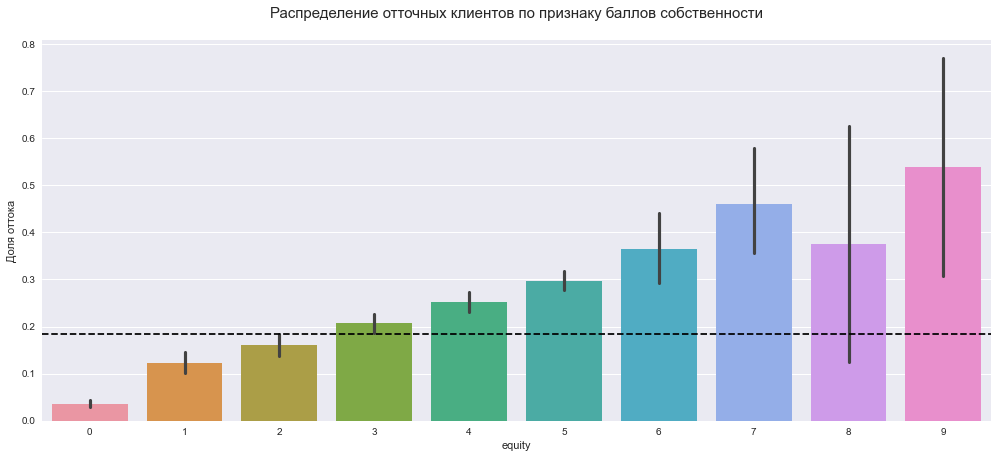

In [33]:
plot_bar('equity', 'баллов собственности')

Из графика видно, что среди отточных клиентов в среднем уровень баллов собственности выше, чем у не отточных клиентов. Причем чем выше уровень баллов собственности, тем больше доля отточных пользователей, почти линейно.

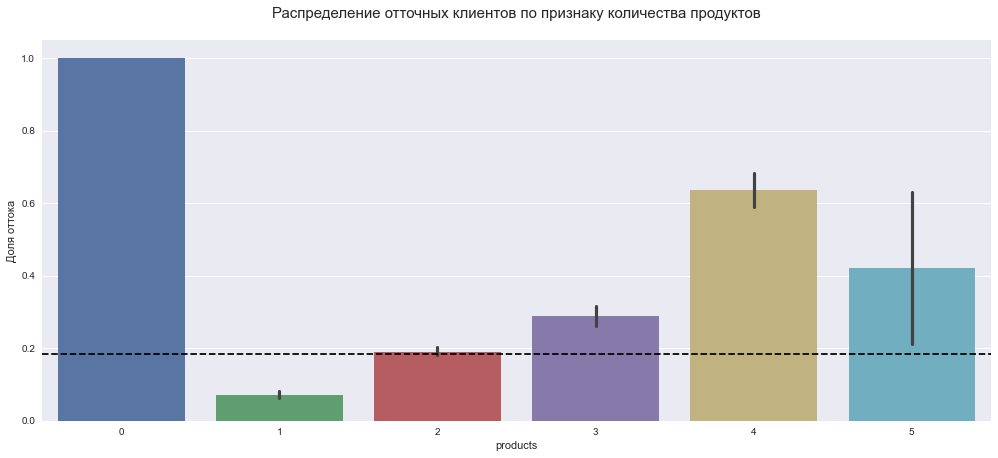

In [34]:
plot_bar('products', 'количества продуктов')

In [35]:
df.query('products == 0 & churn == 1')

,user_id,score,age,equity,balance,products,credit_card,is_active,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
8957,147837,962.0,79.0,3,NaN,0,0,0,25063.96,1,0,1,0,1,0


Отточные клиенты также в среднем имеют большее количество продуктов банка. У клиентов без продуктов банка 100% отток, однако таких клиентов всего один. Больше всего отточных клиентов с 4 продуктами банка.

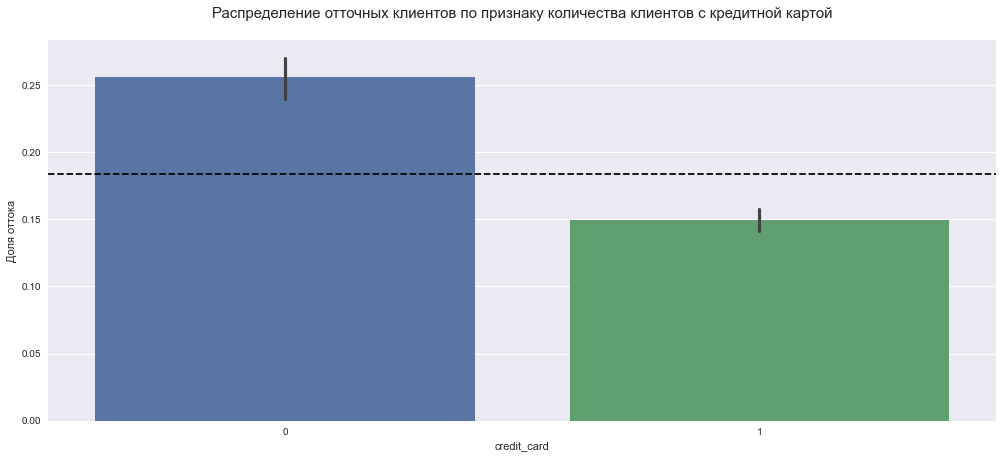

In [36]:
plot_bar('credit_card', 'количества клиентов с кредитной картой')

Среди отточных клиентов в среднем меньше держателей кредитной карты.

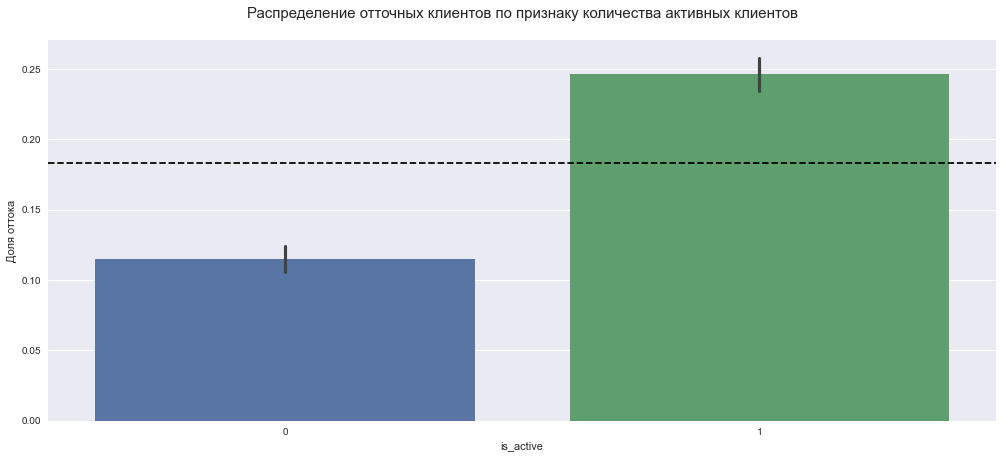

In [37]:
plot_bar('is_active', 'количества активных клиентов')

Среди активных пользователей высокий уровень оттока.

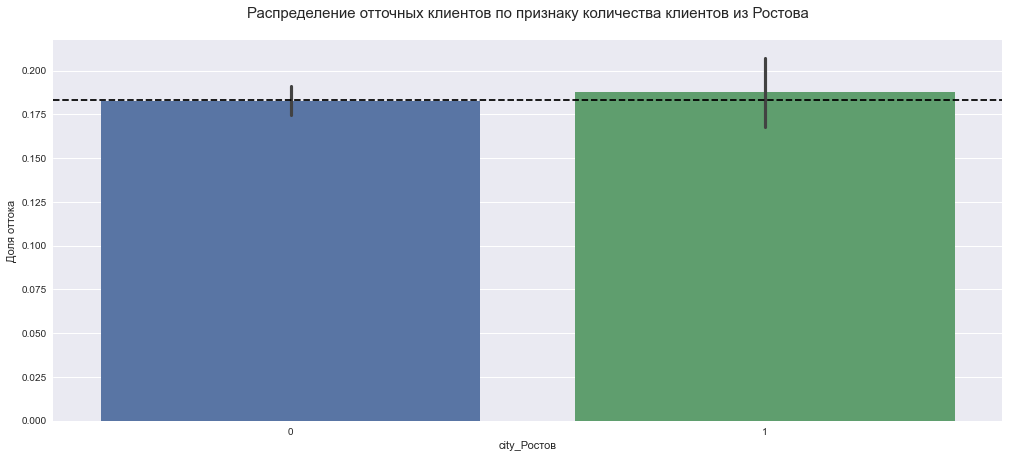

In [38]:
plot_bar('city_Ростов', 'количества клиентов из Ростова')

Доля отточных клиентов среди жителей Ростов примерно такая же, как и среди жителей других городов и в целом по банку.

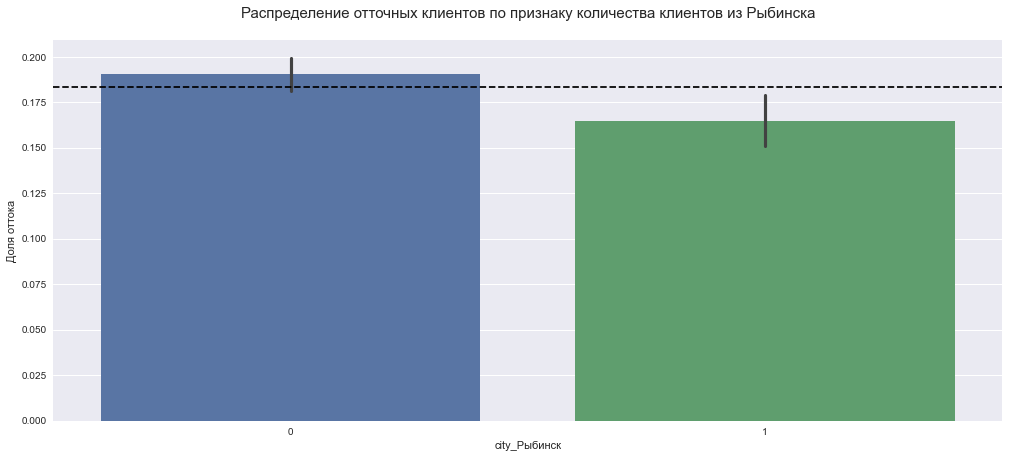

In [39]:
plot_bar('city_Рыбинск', 'количества клиентов из Рыбинска')

Среди жителей Рыбинска доля отточных клиентов немного ниже средней доли оттока клиентов.

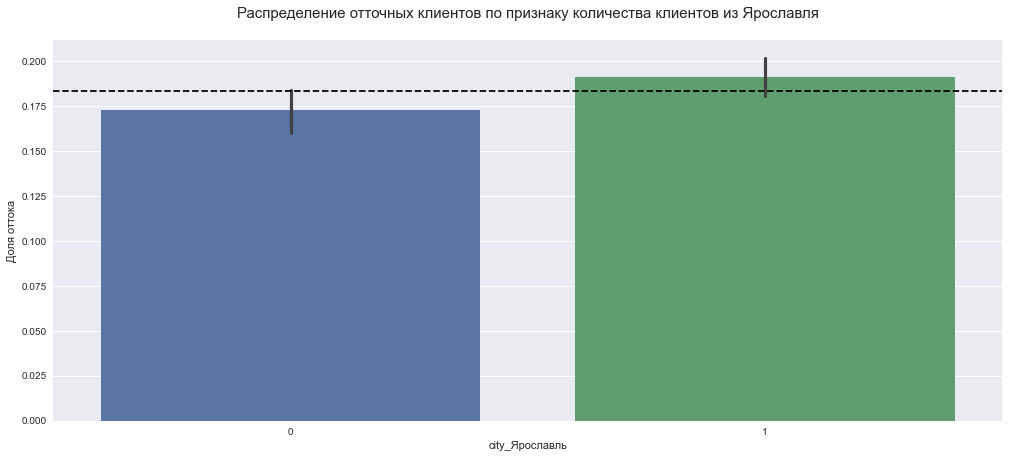

In [40]:
plot_bar('city_Ярославль', 'количества клиентов из Ярославля')

Среди жителей Ярословля доля отточных клиентов слегка выше, чем по клиентам вообще.

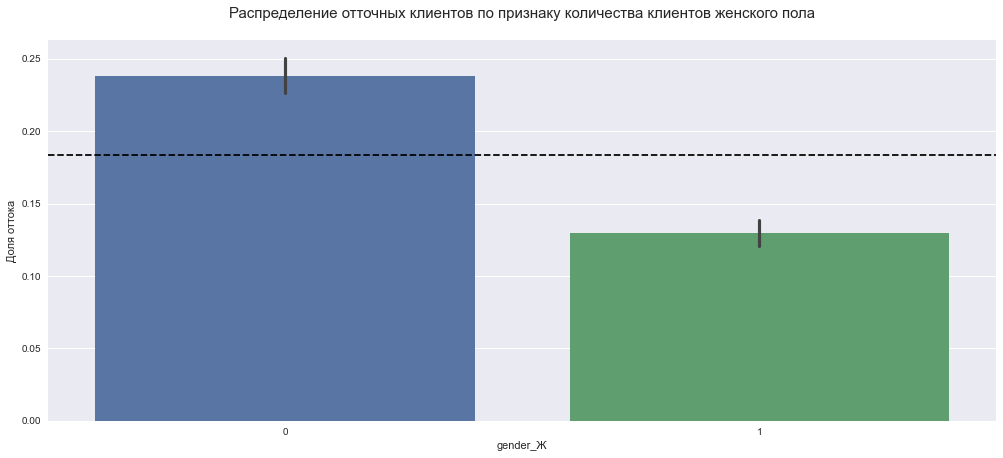

In [41]:
plot_bar('gender_Ж', 'количества клиентов женского пола')

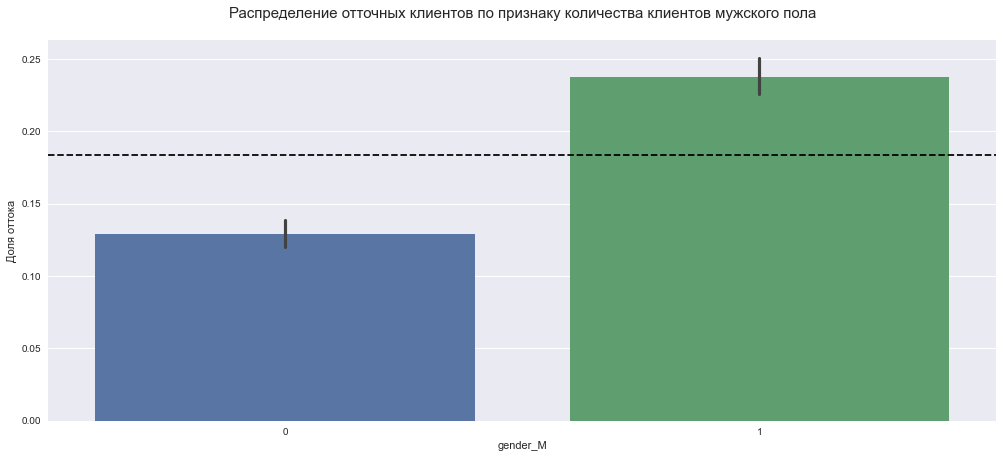

In [42]:
plot_bar('gender_М', 'количества клиентов мужского пола')

Данные по клиентам в зависимости от пола разделились пополам. Однако среди отточных клиентов женщин меньше, чем мужчин.

Рассмотрев признаки клиентов в разрезе оттока, мы выяснили, что есть зависимость от:
 - пола
 - активности
 - наличия кредитной карты
 - баллов собственности
 - баланса на счете
 - возраста
 - баллов кредитного скоринга
 

Рассмотрим портрет клиентов - средние показатели зависимых признаков в разрезе оттока.

In [43]:
portret = (
    df
    .groupby('churn')
    .agg({'score': 'mean', 'age': 'mean', 'equity': 'mean', 'balance': 'mean',
          'products': 'mean', 'credit_card':'median', 'is_active':'median', 'gender_Ж':'median', 'gender_М':'median'})
    .T
    .rename(columns = {0:'stay', 1: 'left'})
)
portret['diff'] = [x - 1 if x > 1 else x for x in (portret['left'] / portret['stay']).round(2)]

portret.apply(lambda s: s.apply(lambda x: format(x, 'g')))

churn,stay,left,diff
score,844.32,861.179,0.02
age,42.9696,41.4421,0.96
equity,2.40395,3.74518,0.56
balance,622124,948217,0.52
products,1.76365,2.37344,0.35
credit_card,1,1,1
is_active,0,1,inf
gender_Ж,1,0,0
gender_М,0,1,inf


Из сводной таблицы можно заметить, что значимая разница в средних показателях есть в колонах `equity`, `balance`, `products`, `is_active`, `gender`.

Теперь посмотрим, как наши признаки коррелируют с оттоком и друг с друг другом.

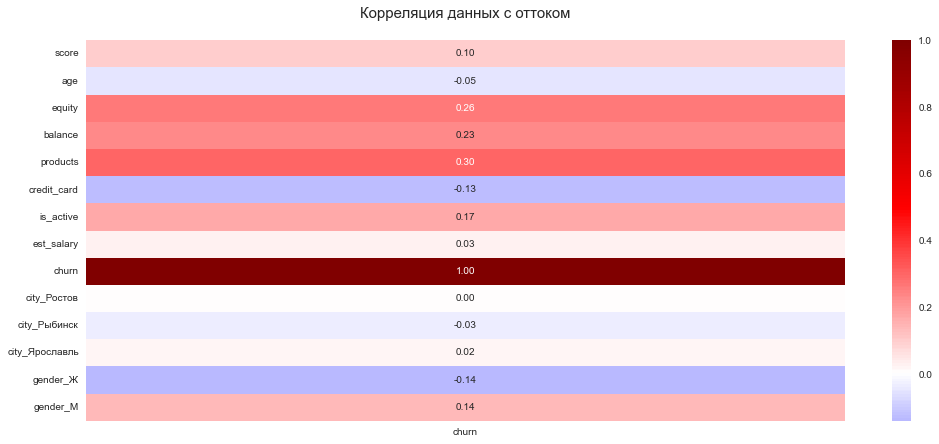

In [44]:
fig, ax = plt.subplots(figsize = (17,7))
sns.heatmap(df.loc[:, 'score':].corr()['churn'].to_frame(), annot=True, fmt=".2f", center=0, cmap='seismic')
ax.set_title('Корреляция данных с оттоком' + '\n', fontsize = 15);

Интерпретируем корреляцию по шкале Чеддока:

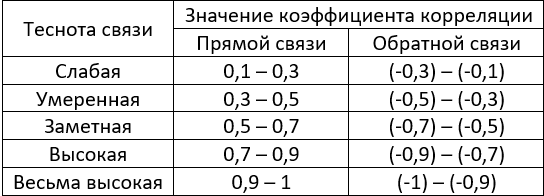

По таблице корреляции можно подтвердить выводы, сделанные ранее. Отток и правда имеет зависимость от
 - пола (с женщинами обратная и слабая, с мужчинами прямая и слабая)
 - активности (прямая и слабая)
 - наличия кредитной карты (обатная слабая)
 - баллов собственности (прямая слабая)
 - баланса на счете (прямая слабая)
 - баллов скоринга (прямая слабая)
 - число продуктов банка (прямая, между слабой и умеренной)

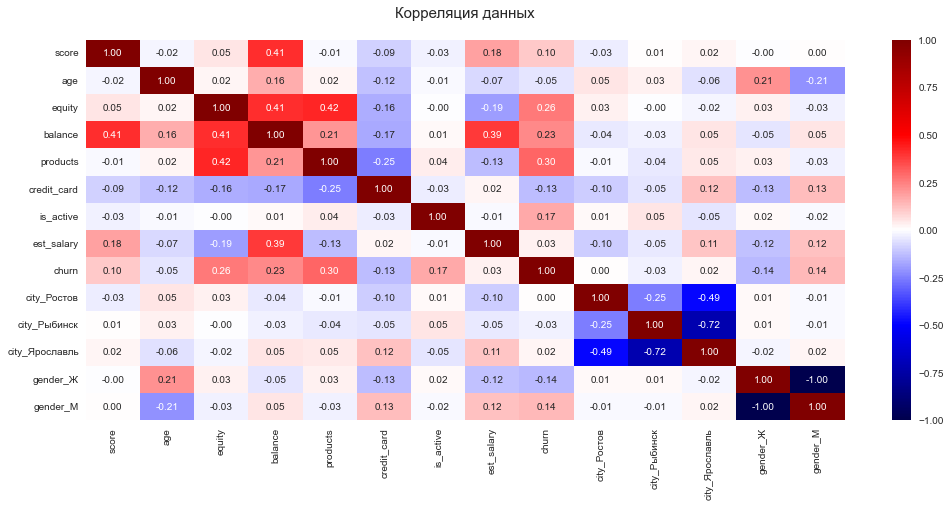

In [45]:
fig, ax = plt.subplots(figsize = (17,7))
sns.heatmap(df.loc[:, 'score':].corr(), annot=True, fmt=".2f", center=0, cmap='seismic')
ax.set_title('Корреляция данных' + '\n', fontsize = 15);

Из общей таблицы интересно заметить:
 - баланс клиента имеет зависимость:
   - прямую умеренную с его баллами скоринга, баллами собственности и заработной платой
   - прямую слабую с возрастом, числом продуктов банка
   - обратную слабуюми с наличием  кредитной карты
 - заработная плата имеет зависимость:
   - прямую слабую со скорингом
   - обратную слабую с баллами собственности и числом продуктов
   - местом проживания (слабая прямая с Ярославлем, слабая обратная с Ростовом)
   - полом (слабая прямая с мужчинами, слабая обратная с женщинами)
 - возраст имеет зависимость:
   - слабую корреляцию с полом клиента (с женщинами - положительную, с мужчинами отрицательную)
 - баллы собственности имеют прямую умеренную зависимость с числом продуктов банка
 - наличие кредитной карты почти со свсеми признаками имеет слабую обратную зависимость

## Проверка гипотез

Первая гипотеза, которую необходимо проверить - это гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались.
Тогда
- $H_0$ : Доход (`est_salary`) ушедших клиентов = доходу (`est_salary`) оставшихся клиентов
- $H_1$ : Доход (`est_salary`) ушедших клиентов ≠ доходу (`est_salary`) оставшихся клиентов

alpha = 0.05

Для проверки гипотезы о равенстве средних двух выборок используют тест Стьюдента. Для использования t-test необходимо, чтобы в данных не было выбросов. Т.е. среднее и медиана были близки. Также посмотрим на размеры сравниваемых выборок и проверим равенство дисперсий.

In [46]:
df.groupby('churn').agg({'est_salary': ['mean', 'median']})

est_salary            
                mean      median
churn                           
0      127720.397847  115771.620
1      133126.165897  122407.515

In [47]:
df.groupby('churn').agg({'est_salary': 'count'})

,est_salary
churn,
0,7840
1,1762


Размер выборок достаточно большой, чтобы использовать `ttest`.

In [48]:
alpha = 0.05

a = df.query('churn == 0')['est_salary']
b = df.query('churn == 1')['est_salary']

stat, p = levene(a, b)

# вывод значения p-value на экран
print(p)

# условный оператор с выводом строки с ответом
if p < alpha:
    print('Отвергаем нулевую гипотезу: выборки имеют разные дисперсии')
else:
    print('Не получилось отвергнуть нулевую гипотезу: выборки имеют равные дисперсии')

0.039005733270021714
Отвергаем нулевую гипотезу: выборки имеют разные дисперсии


В обоих случаях среднее и медиана различаются, но несильно, ведь на этапе предобработки мы избавились от больших выбросов. Выборки имеют большую разницу в размере, однако количество наблюдений в обеих выборках значительно превышают необходимый минимум для того чтобы распределение средних стремилось к нормальному, и статистически значимую разницу в дисперсии. Теперь можно проводить тест с параметром `equal_var=False`.

In [49]:
alpha = 0.05

results = st.ttest_ind(df.query('churn == 0')['est_salary'],
                      df.query('churn == 1')['est_salary'], equal_var=False)


# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

0.00432650997192847
Отвергаем нулевую гипотезу


Между доходом отточных и не отточных клиентов есть разница. 

Вторая гипотеза, которую необходимо, проверить, это гипотеза о возрасте клиентов  между клиентами, которые ушли и теми, которые остались.
Тогда
- $H_0$ : Возраст (`age`) ушедших клиентов = возраст (`age`) оставшихся клиентов
- $H_1$ : Возраст (`age`) ушедших клиентов ≠ возраст (`age`) оставшихся клиентов

alpha = 0.05

In [50]:
df.groupby('churn').agg({'age': ['mean', 'median']})

age       
            mean median
churn                  
0      42.969643   40.0
1      41.442111   39.0

In [51]:
df.groupby('churn').agg({'age': 'count'})

,age
churn,
0,7840
1,1762


In [52]:
alpha = 0.05

a = df.query('churn == 0')['age']
b = df.query('churn == 1')['age']

stat, p = levene(a, b)
p
# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if p < alpha:
    print('Отвергаем нулевую гипотезу: выборки имеют разные дисперсии')
else:
    print('Не получилось отвергнуть нулевую гипотезу: выборки имеют равные дисперсии')

0.00432650997192847
Отвергаем нулевую гипотезу: выборки имеют разные дисперсии


В обоих случаях среднее и медиана различаются, но несильно. Выборки имеют те же размеры, что и в предыдущем тесте, т.е. количество наблюдений в обеих выборках значительно превышают необходимый минимум для того чтобы распределение средних стремилось к нормальному. Дисперсии выборок имеют статистически значимую разницу. Значит можно проводить тест с параметром `equal_var=False`.

In [53]:
alpha = 0.05

results = st.ttest_ind(df.query('churn == 0')['age'],
                      df.query('churn == 1')['age'], equal_var=False)


# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

4.03450630823537e-07
Отвергаем нулевую гипотезу


Между средним возрастом отточных и не отточных клиентов есть статистически значимая разница.

## Промежуточные выводы

Проведя исследовательскую работу мы получили следующие результаты:
- в процессе предобработки были выявлены следующие слабые места данных:
  - наличие большого числа пропусков в колонке баланса клиента
  - не уникальность клиентов по id
- в процессе анализа были выявлены следующие зависимости:
  - Рассмотрев признаки клиентов в разрезе оттока, мы выяснили, что есть зависимость от:
    - пола
    - активности
    - наличия кредитной карты
    - баллов собственности
    - баланса на счете
    - возраста
    - баллов кредитного скоринга
  - Составив портрет клиента на основе зависимых признаков была замечена значимая разница в средних показателях `equity`, `balance`, `products`, `is_active`, `gender`.
  - По таблице корреляции данных с фактом ухода была выявлена слабая зависимость от
    - пола (с женщинами обратная и слабая, с мужчинами прямая и слабая)
    - активности (прямая и слабая)
    - наличия кредитной карты (обатная слабая)
    - баллов собственности (прямая слабая)
    - баланса на счете (прямая слабая)
    - баллов скоринга (прямая слабая)
    - число продуктов банка (прямая, между слабой и умеренной)
- на этапе проверки гипотез было проверено, что
  - Доход ушедших клиентов не равен доходу оставшихся клиентов
  - Возраст ушедших клиентов не равен возрасту оставшихся

Таким образом, во время сегментации мы будет работать со следующими признаками: `gender`, `credit_card`, `balance`, `products`, `score`, `age`, `equity`.


## Сегментация

На основе проведенного анализа, можно приступить к выделению наиболее отточных групп.

Начнем с наиболее коррелируемых характеристик. Первый сегмент - клиенты, имеющие несколько продуктов банка, но без кредитной карты.

In [54]:
print('В сегменте', df.query('credit_card == 0 & products > 1')['user_id'].count(),
      'клиентов. Среди них отточные составляют -',
      round(df.query('credit_card == 0 & products > 1')['churn'].mean(), 2),
      '- причем от общего числа отточных клиентов банка они составляют',
      round(df.query('credit_card == 0 & products > 1')['churn'].sum() / df.query('churn == 1')['user_id'].count(), 2))

В сегменте 2650 клиентов. Среди них отточные составляют - 0.29 - причем от общего числа отточных клиентов банка они составляют 0.43


Первый сегмент показал хороший результат - доля отточных клиентов в группе выше доли отточных клиентов в банке. Более того почти половина отточных клиентов вошла в сегмент.

Следующий сегмент - мужчины возрастомот 25 до 35 лет.

In [55]:
print('В сегменте', df.query('gender_М == 1 & 25 <= age <= 35')['user_id'].count(),
      'клиентов. Среди них отточные составляют -',
      round(df.query('gender_М == 1 & 25 <= age <= 35')['churn'].mean(), 2),
      '- причем от общего числа отточных клиентов банка они составляют',
      round(df.query('gender_М == 1 & 25 <= age <= 35')['churn'].sum() / df.query('churn == 1')['user_id'].count(), 2))

В сегменте 1705 клиентов. Среди них отточные составляют - 0.26 - причем от общего числа отточных клиентов банка они составляют 0.25


Этот сегмент также показал отток выше, чем по банку, однако результат ниже, чем у первого сегмента.

Еще один сегмент - клиенты с высокими показателями баланса и банковским скорингом. Баланс возьмем между 1 и 2 млн, а уровень скоринга между 830 и 900.

In [56]:
print('В сегменте', df.query('1000000 <= balance <= 2000000 & 830 <= score <= 900')['user_id'].count(),
      'клиент. Среди них отточные составляют -',
      round(df.query('1000000 <= balance <= 2000000 & 830 <= score <= 900')['churn'].mean(), 2),
      '- причем от общего числа отточных клиентов банка они составляют -',
      round(df.query('1000000 <= balance <= 2000000 & 830 <= score <= 900')['churn'].sum() / df.query('churn == 1')['user_id'].count(), 2))

В сегменте 631 клиент. Среди них отточные составляют - 0.43 - причем от общего числа отточных клиентов банка они составляют - 0.15


Сегмент получился маленький, но зато целых 42% клиентов внутри него отточные.

Следующий сегмент - мужчины без кредитной карты.

In [57]:
print('В сегменте', df.query('credit_card == 0 & gender_М == 1')['user_id'].count(),
      'клиентов. Среди них отточные составляют -',
      round(df.query('credit_card == 0 & gender_М == 1')['churn'].mean(), 2),
      '- причем от общего числа отточных клиентов банка они составляют',
      round(df.query('credit_card == 0 & gender_М == 1')['churn'].sum() / df.query('churn == 1')['user_id'].count(), 2))

В сегменте 1243 клиентов. Среди них отточные составляют - 0.35 - причем от общего числа отточных клиентов банка они составляют 0.25


Получилась средняя выборка с хорошими показателями.

И последний сегмент - клиенты с большим числом продуктов (от 3 и выше) и большим числом баллов собственности (от 4 и выше).

In [58]:
print('В сегменте', df.query('equity > 3 & products > 2')['user_id'].count(),
      'клиентов. Среди них отточные составляют -',
      round(df.query('equity > 3 & products > 2')['churn'].mean(), 2),
      '- причем от общего числа отточных клиентов банка они составляют',
      round(df.query('equity > 3 & products > 2')['churn'].sum() / df.query('churn == 1')['user_id'].count(), 2))

В сегменте 906 клиентов. Среди них отточные составляют - 0.45 - причем от общего числа отточных клиентов банка они составляют 0.23


Получился небольшой сегмент с высоким уровнем оттока.

## Вывод

Мы получили 5 сегментов разного размера. У всех сегментов уровень оттока выше, чем уровень оттока клиентов по банку в целом, поэтому приоритезировать сегменты будет по доле отточных клиентов, входящих в сегмент. Чем больше уходящих людей задействовано в сегменте, тем лучше он описывает поведение всех отточных людей.

Таким образом, наилучший сегмент - клиенты, у которых несколько продуктов банка, но нет кредитной карты. Затем идет сегмент мужчин без кредитной карты. С такой же долей отточных пользователей по банку, но меньшим уровнем оттока внутри сегмента - молодые мужчины (от 25 до 35 лет). Затем идет сегмент пользователей с большим количеством баллов собственности и большим числом продуктов банка. И последний, но не по значимости, сегмент пользователей с высоким балансом и баллами скоринга.

Что можно сделать для уменьшения отточности таких клиентов? 
1. Можно предположить, что данным клиентам не нравятся условия кредитной карты (ведь другими продуктами банка они охотно пользуются), тогда рекомендацией будет проанализировать рынок предложений других банков, либо  провести опрос среди клиентов без кредитной карты: узнать, почему они не берут карту, и какие условия считают привлекательными.
2. Второму сегменту можно также предложить кредитные карты, но сделать какие-то интересные для мужчин привелегии. Например, создать какую-то программу лояльности для геймеров, спортсменов или автовладельцев.
3. Третьему сегменту также можно сделать специализированное предложение, но на этот раз, например, постоянный повышенный кэшбек за покупки в опредленной сфере. Поскольку клиенты - молодые мужчины, то можно выделить такие категории как бары, электроника, каршеринг, спорт.
4. Клиентам в высокими баллами собственности можно предложить улучшенные условия по продуктам. Продуктов банка у них много, значит новое предлагать смысла нет, нужно заинтересовать тем, что уже есть. Повышенные ставки на вклады, либо особые условия по кредиту.
5. Клиенты последнего сегмента имеют большой баланс. Таким пользователям можно предложить повышение процента и увеличение лимита на вклад или накопительный счет. Также можно предложить высокий процент на остаток для дебетовых карт.

Презентация: https://disk.yandex.ru/d/SuXrDq35mM3V6g

Дашборд: https://public.tableau.com/app/profile/anastasiya.vtyurina/viz/bank_clients_1/1?publish=yes